In [2]:
import cv2
import numpy as np
import pandas as pd
import os 
import torch
import torch.nn.functional as F
import torchvision

from tqdm import tqdm

In [3]:
data_dir = '../../osic-pulmonary-fibrosis-progression'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import random

# Input: List of patient_id
# Output: Tuple of (train_patient_ids, val_patient_ids)
# train_ratio: Ratio of training set
def train_val_split(patients: pd.DataFrame, train_ratio: float = 0.8) -> (pd.DataFrame, pd.DataFrame):
  patient_ids = patients['Patient'].unique()
  random.shuffle(patient_ids)

  train_patients = patients[patients['Patient'].isin(patient_ids[:int(len(patient_ids) * train_ratio)])]
  val_patients = patients[patients['Patient'].isin(patient_ids[int(len(patient_ids) * train_ratio):])]

  return train_patients, val_patients

In [25]:
# Prepare train and val data
train_patients = pd.read_csv(data_dir + '/train.csv')
test_patients = pd.read_csv(data_dir + '/test.csv')

# Remove row in train data if patient_id is in test_patient_ids
train_patients = train_patients[~train_patients['Patient'].isin(test_patients)]

# Group by patient and get the first FVC value
patient_id_to_initial_FVC = train_patients.groupby('Patient')['FVC'].first().to_dict()
train_patients, val_patients = train_val_split(train_patients)

# Sort df by patient and then by 'Weeks'
train_patients = train_patients.sort_values(by=['Patient', 'Weeks'])

In [6]:
# Edge detection using Sobel operator
def extract_edge(image_array: np.ndarray, batching: bool = False) -> list[np.ndarray]:
  if device == torch.device('cuda'):
    batch = torch.tensor(image_array, dtype=torch.float32, device=device)
    # Convert to batch tensor (N, 1, H, W)
    if not batching:
      batch = batch.unsqueeze(0).unsqueeze(0)

    # Define Sobel kernels
    sobel_x = torch.tensor([
      [-1, 0, 1],
      [-2, 0, 2],
      [-1, 0, 1]
    ], dtype=torch.float32, device=device).view(1, 1, 3, 3)
    
    sobel_y = torch.tensor([
      [-1, -2, -1],
      [ 0,  0,  0],
      [ 1,  2,  1]
    ], dtype=torch.float32, device=device).view(1, 1, 3, 3)
    
    # Apply Sobel filters to entire batch
    edges_x = F.conv2d(batch, sobel_x, padding=1)
    edges_y = F.conv2d(batch, sobel_y, padding=1)
    
    # Compute magnitude
    edges = 0.5 * torch.abs(edges_x) + 0.5 * torch.abs(edges_y)
    
    # Convert back to list of numpy arrays
    edges = edges.cpu().numpy()
    if not batching:
      edges = edges[0, 0]
    else:
      edges = edges[:, 0]

    del batch, edges_x, edges_y
    
    return edges
    
  edgesX = cv2.Sobel(image_array, cv2.CV_64F, 1, 0, ksize=3)
  edgesY = cv2.Sobel(image_array, cv2.CV_64F, 0, 1, ksize=3)
  absEdgesX = cv2.convertScaleAbs(edgesX)
  absEdgesY = cv2.convertScaleAbs(edgesY)
  edges = cv2.addWeighted(absEdgesX, 0.5, absEdgesY, 0.5, 0)
  return edges

In [7]:
def extract_corner(image_array: np.ndarray, block_size=2, ksize=3, k=0.04, batching: bool = False) -> list[np.ndarray]:
  if device == torch.device('cuda'):
    batch = torch.tensor(image_array, dtype=torch.float32, device=device)
    
    # Convert to batch tensor (N, 1, H, W)
    if not batching:
      batch = batch.unsqueeze(0).unsqueeze(0)
    
    # Sobel kernels
    sobel_x = torch.tensor([
      [-1, 0, 1],
      [-2, 0, 2],
      [-1, 0, 1]
    ], dtype=torch.float32, device=device).view(1, 1, ksize, ksize)
    
    sobel_y = torch.tensor([
      [-1, -2, -1],
      [ 0,  0,  0],
      [ 1,  2,  1]
    ], dtype=torch.float32, device=device).view(1, 1, ksize, ksize)
    
    # Compute gradients for entire batch
    Ix = F.conv2d(batch, sobel_x, padding=1)
    Iy = F.conv2d(batch, sobel_y, padding=1)
    
    # Derivative products
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy
    
    # Gaussian kernel
    sigma = block_size / 2.0
    kernel_size = block_size * 2 + 1
    x = torch.arange(kernel_size, dtype=torch.float32, device=device) - kernel_size // 2
    gaussian_1d = torch.exp(-x ** 2 / (2 * sigma ** 2))
    gaussian_1d = gaussian_1d / gaussian_1d.sum()
    gaussian_2d = gaussian_1d.view(-1, 1) * gaussian_1d.view(1, -1)
    gaussian_2d = gaussian_2d.view(1, 1, kernel_size, kernel_size)
    
    # Apply Gaussian weighting
    padding = kernel_size // 2
    Sxx = F.conv2d(Ixx, gaussian_2d, padding=padding)
    Syy = F.conv2d(Iyy, gaussian_2d, padding=padding)
    Sxy = F.conv2d(Ixy, gaussian_2d, padding=padding)
    
    # Harris response for entire batch
    det = Sxx * Syy - Sxy * Sxy
    trace = Sxx + Syy
    harris_response = det - k * (trace * trace)
    
    # Apply threshold per image
    corners_list = []
    for i in range(harris_response.shape[0]):
      response = harris_response[i, 0]
      threshold = 0.05 * response.max()
      corners = response > threshold
      corners = corners.cpu().numpy().astype(np.float32)
      corners_list.append(corners)
    corners_list = np.array(corners_list)

    del batch, harris_response, Sxx, Syy, Sxy, Ixx, Iyy, Ixy, Ix, Iy
    if not batching:
      return corners_list[0]
    else:
      return corners_list
  
  # Apply cornerHarris
  score = cv2.cornerHarris(image_array, block_size, ksize, k)
  # 0.05 is a threshold to determine if a corner is valid
  corners = score > 0.05 * score.max()

  # Could consider returning original score without thresholding
  return corners


In [8]:
def extract_blob(image_array, batching: bool = False):
  if device == torch.device('cuda'):
    batch = torch.tensor(image_array, dtype=torch.float32, device=device)
    
    # Convert to batch tensor (N, 1, H, W)
    if not batching:
      batch = batch.unsqueeze(0).unsqueeze(0)

    # Apply blurs to entire batch
    blurred1 = torchvision.transforms.functional.gaussian_blur(batch, kernel_size=(5, 5), sigma=(0.8, 0.8))
    blurred2 = torchvision.transforms.functional.gaussian_blur(batch, kernel_size=(11, 11), sigma=(1.8, 1.8))
    
    # Compute DoG for entire batch
    dog = blurred1 - blurred2
    
    # Normalize each image separately
    results = []
    for i in range(dog.shape[0]):
      dog_single = dog[i, 0]
      dog_min = dog_single.min()
      dog_max = dog_single.max()
      dog_normalized = (dog_single - dog_min) / (dog_max - dog_min + 1e-8) * 255
      results.append(dog_normalized.cpu().numpy())
    
    del batch, blurred1, blurred2, dog, dog_single, dog_min, dog_max, dog_normalized
    results = np.array(results)
    if not batching:
      return results[0]
    else:
      return results

  # Use DoG (Difference of Gaussian) to detect blobs
  # First, apply GaussianBlur to the image
  blurred1 = cv2.GaussianBlur(image_array, (5, 5), 0.8)
  blurred2 = cv2.GaussianBlur(image_array, (11, 11), 1.8)

  # Then, compute the difference between the blurred image and the original image
  dog = cv2.subtract(blurred1, blurred2)

  # minmax normalize the result to enhance contrast
  dog = cv2.normalize(dog, None, 0, 255, cv2.NORM_MINMAX)

  return dog

In [9]:
def extract_local_binary_pattern(image_array, batching: bool = False):
  if device == torch.device('cuda'):
    image = torch.tensor(image_array, dtype=torch.float32, device=device)
    
    # Convert to batch tensor (N, 1, H, W)
    if not batching:
      image = image.unsqueeze(0).unsqueeze(0)

    # Create kernels for extracting each neighbor
    neighbor_kernels = []
    positions = [
      (0, 0), (0, 1), (0, 2),  # Top row
      (1, 2),                   # Right
      (2, 2), (2, 1), (2, 0),  # Bottom row
      (1, 0)                    # Left
    ]
    
    for i, (row, col) in enumerate(positions):
      kernel = torch.zeros(1, 1, 3, 3, device=device)
      kernel[0, 0, row, col] = 1.0
      neighbor_kernels.append(kernel)
    
    # Extract center pixel value
    center_kernel = torch.zeros(1, 1, 3, 3, device=device)
    center_kernel[0, 0, 1, 1] = 1.0
    center = F.conv2d(image, center_kernel, padding=1)
  
    # Initialize LBP
    lbp_image = torch.zeros_like(center)
    
    # Compare each neighbor
    for k, kernel in enumerate(neighbor_kernels):
      neighbor = F.conv2d(image, kernel, padding=1)
      comparison = (neighbor >= center).float()
      lbp_image += comparison * (2 ** k)
    
    result = lbp_image.cpu().numpy()

    del image, center, center_kernel, neighbor_kernels, neighbor, comparison, lbp_image

    if not batching:
      return result[0][0]
    else:
      return result.squeeze(1)

  # Use CPU otherwise
  # Get image dimensions
  height, width = image_array.shape

  # Initialize LBP image
  lbp_image = np.zeros_like(image_array)

  # Define 8-neighborhood offsets (8-connected)
  offsets = [(-1, -1), (-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1)]

  # Apply LBP to each pixel (excluding border pixels)
  for i in range(1, height - 1):
    for j in range(1, width - 1):
      center_pixel = image_array[i, j]
      binary_pattern = 0

      # Compare center pixel with 8 neighbors
      for k, (di, dj) in enumerate(offsets):
        neighbor_pixel = image_array[i + di, j + dj]
        if neighbor_pixel >= center_pixel:
          binary_pattern |= (1 << k)

      lbp_image[i, j] = binary_pattern

  return lbp_image


In [10]:
def extract_gabor_feature(image_array, batching: bool = False):
  # Define Gabor filter parameters
  orientations = [0, 45, 90, 135]  # 4 orientations in degrees
  frequencies = [0.1, 0.2, 0.3]   # 3 different frequencies
  sigma = 2.0  # Standard deviation of Gaussian envelope
  gamma = 0.5  # Spatial aspect ratio

  # Initialize feature maps
  gabor_features = []

  if device == torch.device('cuda') and not batching:
    image_array = torch.tensor(image_array, dtype=torch.float32, device=device)
    image_array = image_array.unsqueeze(0).unsqueeze(0)
  elif device == torch.device('cuda'):
    image_array = torch.tensor(image_array, dtype=torch.float32, device=device)

  # Apply Gabor filters with different orientations and frequencies
  for orientation in orientations:
    for frequency in frequencies:
      # Convert orientation to radians
      theta = np.radians(orientation)

      # Create Gabor kernel
      kernel = cv2.getGaborKernel(
        ksize=(15, 15),  # Kernel size
        sigma=sigma,
        theta=theta,
        lambd=1.0/frequency,  # Wavelength
        gamma=gamma,
        psi=0,  # Phase offset
        ktype=cv2.CV_32F
      )

      if device == torch.device('cuda'):
        kernel = torch.tensor(kernel, dtype=torch.float32, device=device)
        kernel = kernel.unsqueeze(0).unsqueeze(0)
        filtered = F.conv2d(image_array, kernel, padding=7)
        magnitude = torch.abs(filtered)
        
        min_val = magnitude.min()
        max_val = magnitude.max()

        # Apply the min-max normalization formula
        normalized_data = (magnitude - min_val) / (max_val - min_val)

        gabor_feature = normalized_data.cpu().numpy()
        del magnitude, min_val, max_val, normalized_data, filtered
        gabor_features.append(gabor_feature)

      else:
        # Apply filter
        filtered = cv2.filter2D(image_array, cv2.CV_32F, kernel)

        # Take magnitude of response
        magnitude = np.abs(filtered)

        # Normalize to 0-255 range
        magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

        gabor_features.append(magnitude)

  # Combine all Gabor responses (mean of all filter responses)
  combined_gabor = np.mean(gabor_features, axis=0)

  if not batching:
    return combined_gabor[0][0]
  return combined_gabor


In [11]:
import pydicom

# Read indivudal scans from DICOM files
def read_dicom(path):
  dicom = pydicom.dcmread(path)
  # Convert image to float32
  image_array = np.float32(dicom.pixel_array)
  return image_array

In [12]:
def organize_dicom():
    # Reorganize numbering for dicom files in each patient folder
    for patient_id in os.listdir(f'{data_dir}/train'):
        # Rename each file into according order
        existing_files = os.listdir(f'{data_dir}/train/{patient_id}/')
        existing_files.sort(key=lambda x: int(x.split('.')[0]))
        for i, file_name in enumerate(existing_files):
            os.rename(f'{data_dir}/train/{patient_id}/{file_name}', f'{data_dir}/train/{patient_id}/{i+1}.dcm')

organize_dicom()

In [13]:
import os
import pandas as pd
from concurrent.futures import ProcessPoolExecutor

from preprocess import preprocess_dicom

tabular = pd.read_csv(f'{data_dir}/train.csv')
patient_ids = tabular['Patient'].unique()

def get_patient_scans_path(patient_id):
  dir_size = len(os.listdir(f'{data_dir}/train/{patient_id}/'))
  return [f'{data_dir}/train/{patient_id}/{i}.dcm' for i in range(1, dir_size + 1)]

def load_patient_dicom_scans(patient_id):
  scan_paths = get_patient_scans_path(patient_id)
  dcms = []
  for scan_path in scan_paths:
    try:
      dcm = pydicom.dcmread(scan_path)
      # Make sure pixel_array is readable
      pixel_array = dcm.pixel_array
      dcms.append(dcm)
    except Exception as e:
      print(f'Patient {patient_id} have undecodable pixel_array. Error: {e}')
      return np.array([], dtype=np.float32)
  preprocessed_scans = preprocess_dicom(patient_id, dcms)
  patient_scans = np.array(preprocessed_scans, dtype=np.float32)
  return patient_scans

Using device: cuda


In [14]:
idx_to_feature_name = ['edge', 'corner', 'blob', 'lbp', 'gabor']
idx_to_feature_extractor = [extract_edge, extract_corner, extract_blob, extract_local_binary_pattern, extract_gabor_feature]

def extract_features(scan, batching: bool = False):
  features = []
  with torch.no_grad():
    for i in range(len(idx_to_feature_extractor)):
      features.append(idx_to_feature_extractor[i](scan, batching=batching))
  return np.array(features)

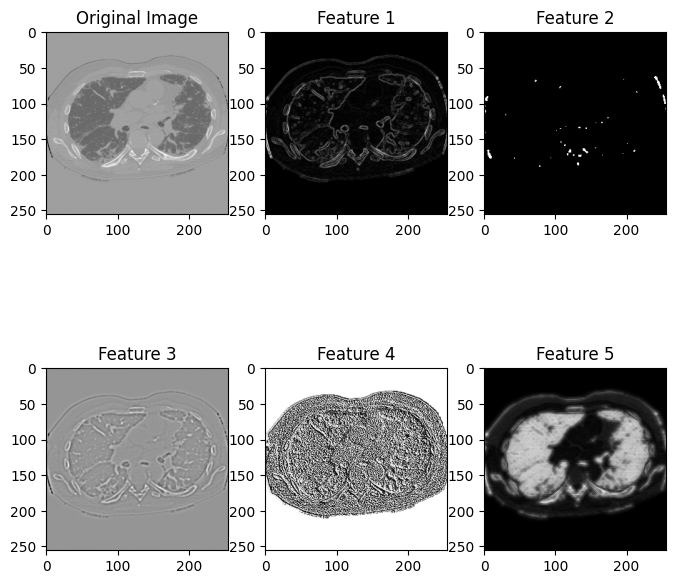

In [15]:
import matplotlib.pyplot as plt

patient_id = train_patients.iloc[0].Patient
scans = load_patient_dicom_scans(patient_id)
features = extract_features(scans[15])

# Compare original image to features
fig, axs = plt.subplots(2, 3, figsize=(8, 8))
axs[0][0].imshow(scans[15], cmap='gray')
axs[0][0].set_title('Original Image')
for row in range(2):
  for col in range(3):
    if row == 0 and col == 0:
      continue
    axs[row][col].imshow(features[row * 3 + col - 1], cmap='gray')
    axs[row][col].set_title(f'Feature {row * 3 + col}')
plt.show()

##### Use Preprocessed Scans

In [16]:
def load_patient_scans(patient_id, scan_batch_size: int = 12):
  if not os.path.exists(f'{data_dir}/preprocessed_scans/{patient_id}'):
    return None
  patient_scan_count = len(os.listdir(f'{data_dir}/preprocessed_scans/{patient_id}'))
  skip_size = patient_scan_count // scan_batch_size
  remainder = patient_scan_count % scan_batch_size
  scans = []
  curr = 0
  while curr < patient_scan_count:
    scan = np.load(f'{data_dir}/preprocessed_scans/{patient_id}/{curr+1}.npy')
    scans.append(scan)
    curr += skip_size

    # Ensure exactly #scan_batch_size number of scans
    if remainder > 0:
      remainder -= 1
      curr += 1

    if scans[-1].shape[1] != 512:
      scan = scans[-1]
      scan = scan.squeeze()
      resized_scan = cv2.resize(scan, (512, 512), interpolation=cv2.INTER_LINEAR)
      resized_scan = resized_scan.reshape(1, 512, 512)
      scans[-1] = resized_scan
      # Overwrite the npy file
      np.save(f'{data_dir}/preprocessed_scans/{patient_id}/{curr+1}.npy', scans[-1])
    
  return np.array(scans)

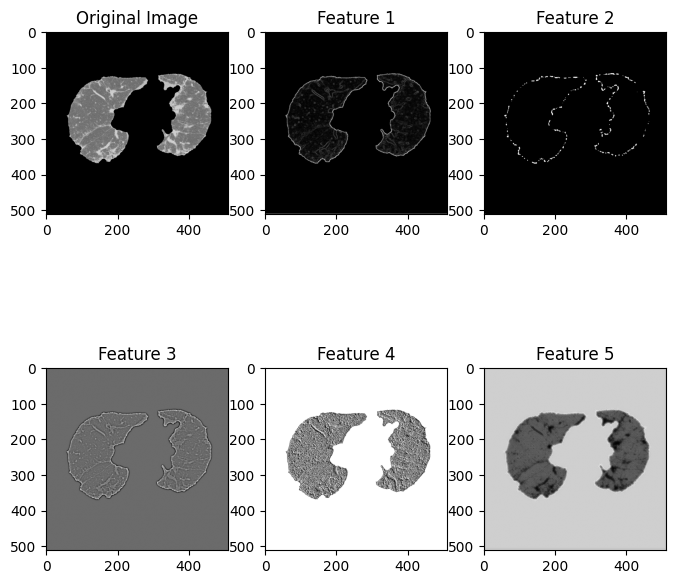

In [17]:
patient_id = train_patients.iloc[0].Patient
scans = load_patient_scans(patient_id)
features = extract_features(scans[5].squeeze())

# Compare original image to features
fig, axs = plt.subplots(2, 3, figsize=(8, 8))
axs[0][0].imshow(scans[5].squeeze(), cmap='gray')
axs[0][0].set_title('Original Image')
for row in range(2):
  for col in range(3):
    if row == 0 and col == 0:
      continue
    axs[row][col].imshow(features[row * 3 + col - 1], cmap='gray')
    axs[row][col].set_title(f'Feature {row * 3 + col}')
plt.show()

### Approach 1: Use random forest to regress on individual scan and individual features

In [26]:
from typing import Any


from collections import defaultdict

x_train = defaultdict(list)
y_train = defaultdict(list)

for row in train_patients.itertuples():
  patient_id = row.Patient    
  x_train[patient_id].append({
    'initial_FVC': patient_id_to_initial_FVC[patient_id],
    'week': row.Weeks
  })
  y_train[patient_id].append(row.FVC)

x_val = defaultdict(list)
y_val = defaultdict(list)

for row in val_patients.itertuples():
  patient_id = row.Patient    
  x_val[patient_id].append({
    'initial_FVC': patient_id_to_initial_FVC[patient_id],
    'week': row.Weeks
  })
  y_val[patient_id].append(row.FVC)

In [ ]:
import pickle
from sklearn.decomposition import PCA

pcas = []
pca_component_count = [3500, 4000, 3000, 3000, 1000]

for i in range(5):
    features = []
    for patient_id in tqdm(x_train.keys()):
        patient_scans = load_patient_scans(patient_id, scan_batch_size=64)
        if patient_scans is None:
            continue
        feature = idx_to_feature_extractor[i](patient_scans, batching=True)
        feature = [f.flatten() for f in feature]
        features += feature

    features = np.array(features)
    component_cnt = pca_component_count[i]
    pca = PCA(n_components=component_cnt)
    pca.fit(features)
    print(f"PCA explained variance, component count {pca.n_components_} : {pca.explained_variance_ratio_.sum()}")
    with open(f'{data_dir}/trained_model/pca_feat{i}.pkl', 'wb') as file:
        pickle.dump(pca, file)
    pcas.append(pca)

100%|██████████| 140/140 [00:31<00:00,  4.48it/s]


PCA explained variance, component count 3500 : 0.8898639678955078


100%|██████████| 140/140 [00:31<00:00,  4.40it/s]


PCA explained variance, component count 4000 : 0.887012243270874


100%|██████████| 140/140 [00:32<00:00,  4.33it/s]


PCA explained variance, component count 3000 : 0.9040356874465942


100%|██████████| 140/140 [00:45<00:00,  3.05it/s]


PCA explained variance, component count 3000 : 0.8979100584983826


100%|██████████| 140/140 [02:05<00:00,  1.12it/s]


PCA explained variance, component count 2500 : 0.9940632581710815


## RF for each feature

In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# For each feature, find best n_estimator
n_estimators = [100, 200, 300, 400, 500]
best_n_estimator = [0] * 5
best_mse_list = [float('inf')] * 5

for i in range(5):
    rfs = [RandomForestRegressor(n_estimators=n_estimator, random_state=42) for n_estimator in n_estimators]
    features = []
    targets = []
    for patient_id in tqdm(x_train.keys()):
        patient_scans = load_patient_scans(patient_id, scan_batch_size=64)
        if patient_scans is None:
            continue
        feature = idx_to_feature_extractor[i](patient_scans, batching=True)
        feature = np.array([f.flatten() for f in feature])
        feature = np.mean(feature, axis=0).reshape(1, -1)
        feature = pcas[i].transform(feature)
        feature = feature.flatten()
        for j in range(len(x_train[patient_id])):
            x = x_train[patient_id][j]
            y = y_train[patient_id][j]

            features.append(np.array(feature.tolist()+list(x.values())))
            targets.append(y)
    for rf in rfs:
        rf.fit(features, targets)

    # Test on validation set
    features = []
    targets = []
    for patient_id in tqdm(x_val.keys()):
        patient_scans = load_patient_scans(patient_id, scan_batch_size=64)
        if patient_scans is None:
            continue
        feature = idx_to_feature_extractor[i](patient_scans, batching=True)
        feature = np.array([f.flatten() for f in feature])
        feature = np.mean(feature, axis=0).reshape(1, -1)
        feature = pcas[i].transform(feature)
        feature = feature.flatten()
        
        for j in range(len(x_val[patient_id])):
            x = x_val[patient_id][j]
            y = y_val[patient_id][j]

            features.append(np.array(feature.tolist()+list(x.values())))
            targets.append(y)
    for estimator_idx, rf in enumerate(rfs):
        predictions = rf.predict(features)
        mse = mean_squared_error(targets, predictions)
        
        print(f"Feature {idx_to_feature_name[i]}, n_estimator {n_estimators[estimator_idx]}, MSE: {mse:.2f}")
        if mse < best_mse_list[i]:
            best_mse_list[i] = mse
            best_n_estimator[i] = n_estimators[estimator_idx]
    print(f"Best n_estimator for feature {idx_to_feature_name[i]}: {best_n_estimator[i]}")
        

        

100%|██████████| 36/36 [00:14<00:00,  2.55it/s]


Feature edge, n_estimator 100, MSE: 61228.19
Feature edge, n_estimator 200, MSE: 62801.29
Feature edge, n_estimator 300, MSE: 61630.88
Feature edge, n_estimator 400, MSE: 62274.48
Feature edge, n_estimator 500, MSE: 61895.64
Best n_estimator for feature edge: 100


100%|██████████| 36/36 [00:17<00:00,  2.11it/s]


Feature corner, n_estimator 100, MSE: 62088.48
Feature corner, n_estimator 200, MSE: 63004.76
Feature corner, n_estimator 300, MSE: 62811.35
Feature corner, n_estimator 400, MSE: 62375.98
Feature corner, n_estimator 500, MSE: 62344.69
Best n_estimator for feature corner: 100


100%|██████████| 36/36 [00:12<00:00,  2.85it/s]


Feature blob, n_estimator 100, MSE: 73997.72
Feature blob, n_estimator 200, MSE: 73584.14
Feature blob, n_estimator 300, MSE: 73764.76
Feature blob, n_estimator 400, MSE: 73740.70
Feature blob, n_estimator 500, MSE: 72393.02
Best n_estimator for feature blob: 500


100%|██████████| 36/36 [00:12<00:00,  2.87it/s]


Feature lbp, n_estimator 100, MSE: 63405.21
Feature lbp, n_estimator 200, MSE: 64193.76
Feature lbp, n_estimator 300, MSE: 62858.09
Feature lbp, n_estimator 400, MSE: 62216.55
Feature lbp, n_estimator 500, MSE: 61529.26
Best n_estimator for feature lbp: 500


100%|██████████| 36/36 [00:23<00:00,  1.51it/s]

Feature gabor, n_estimator 100, MSE: 61955.59
Feature gabor, n_estimator 200, MSE: 60066.05
Feature gabor, n_estimator 300, MSE: 58960.05
Feature gabor, n_estimator 400, MSE: 58271.41
Feature gabor, n_estimator 500, MSE: 58437.34
Best n_estimator for feature gabor: 400


In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# For each feature, find best n_estimator
n_estimators = [40, 60, 70, 80, 90]
best_n_estimator = 0
best_mse = float('inf')

i = 0
rfs = [RandomForestRegressor(n_estimators=n_estimator, random_state=42) for n_estimator in n_estimators]
features = []
targets = []
for patient_id in tqdm(x_train.keys()):
    patient_scans = load_patient_scans(patient_id, scan_batch_size=64)
    if patient_scans is None:
        continue
    feature = idx_to_feature_extractor[i](patient_scans, batching=True)
    feature = np.array([f.flatten() for f in feature])
    feature = np.mean(feature, axis=0).reshape(1, -1)
    feature = pcas[i].transform(feature)
    feature = feature.flatten()
    for j in range(len(x_train[patient_id])):
        x = x_train[patient_id][j]
        y = y_train[patient_id][j]

        features.append(np.array(feature.tolist()+list(x.values())))
        targets.append(y)
for rf in rfs:
    rf.fit(features, targets)

# Test on validation set
features = []
targets = []
for patient_id in tqdm(x_val.keys()):
    patient_scans = load_patient_scans(patient_id, scan_batch_size=64)
    if patient_scans is None:
        continue
    feature = idx_to_feature_extractor[i](patient_scans, batching=True)
    feature = np.array([f.flatten() for f in feature])
    feature = np.mean(feature, axis=0).reshape(1, -1)
    feature = pcas[i].transform(feature)
    feature = feature.flatten()
    
    for j in range(len(x_val[patient_id])):
        x = x_val[patient_id][j]
        y = y_val[patient_id][j]

        features.append(np.array(feature.tolist()+list(x.values())))
        targets.append(y)
for estimator_idx, rf in enumerate(rfs):
    predictions = rf.predict(features)
    mse = mean_squared_error(targets, predictions)
    
    print(f"Feature {idx_to_feature_name[i]}, n_estimator {n_estimators[estimator_idx]}, MSE: {mse:.2f}")
    if mse < best_mse:
        best_mse = mse
        best_n_estimator = n_estimators[estimator_idx]
print(f"Best n_estimator for feature {idx_to_feature_name[i]}: {best_n_estimator}")

100%|██████████| 36/36 [00:17<00:00,  2.01it/s]

Feature edge, n_estimator 40, MSE: 61374.80
Feature edge, n_estimator 60, MSE: 62508.74
Feature edge, n_estimator 70, MSE: 62121.05
Feature edge, n_estimator 80, MSE: 61501.22
Feature edge, n_estimator 90, MSE: 62029.79
Best n_estimator for feature edge: 40


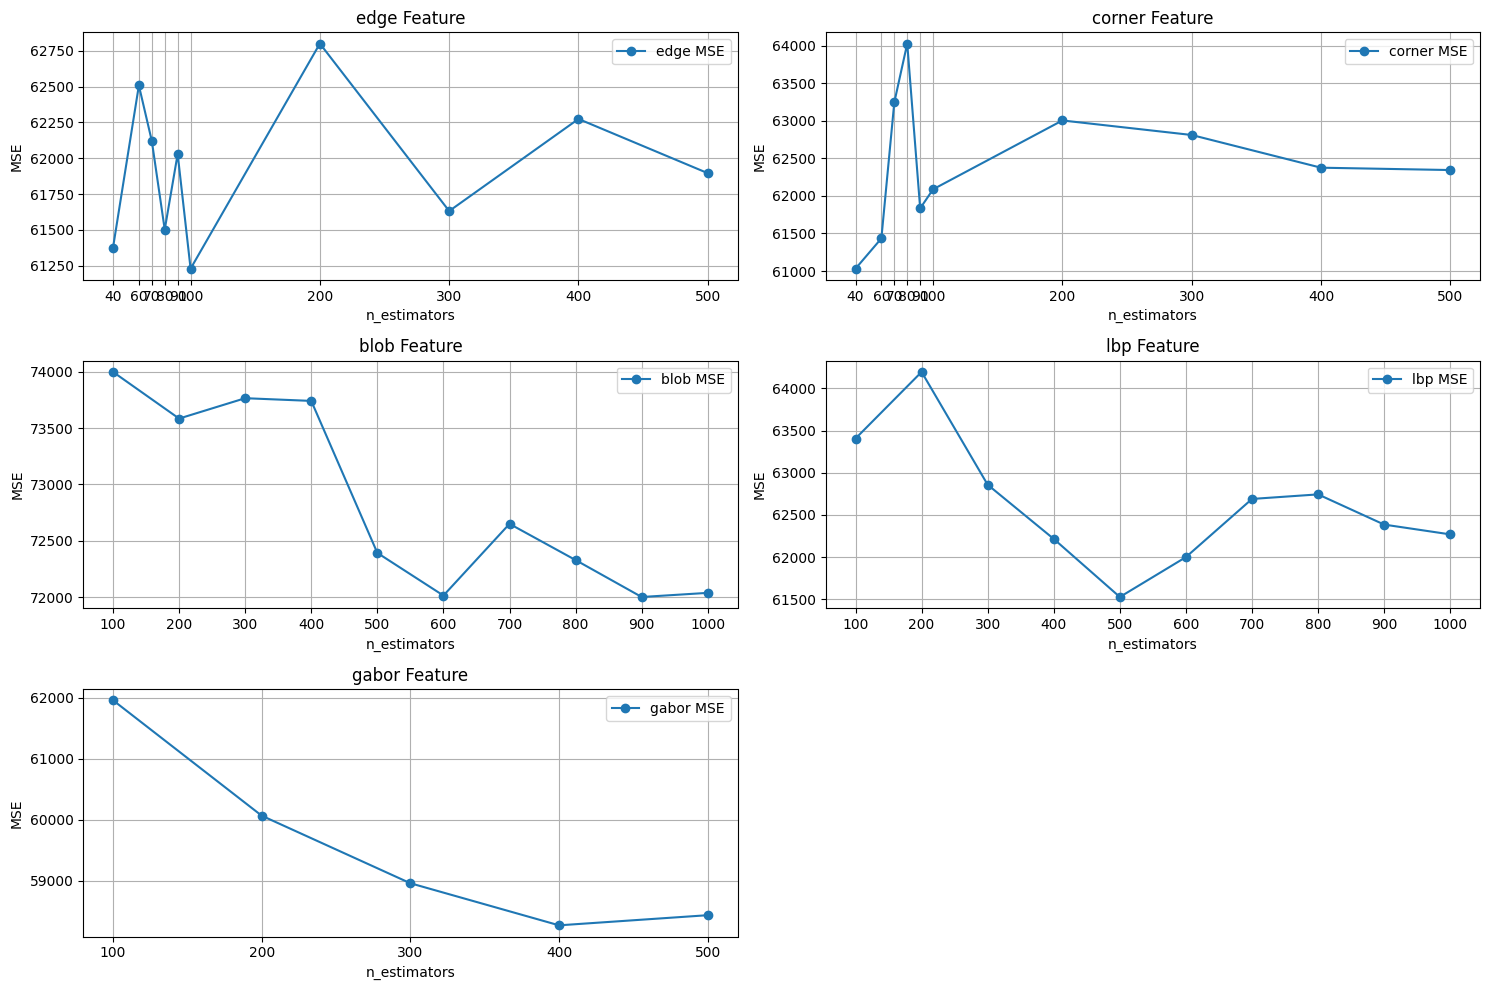

In [73]:
n_estimators = [100, 200, 300, 400, 500]
lower_n_estimators = [40, 60, 70, 80, 90, 100, 200, 300, 400, 500]
longer_n_estimators = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
edge_mse = [61374.80, 62508.74, 62121.05, 61501.22, 62029.79, 61228.19, 62801.29, 61630.88, 62274.48, 61895.64]
corner_mse = [61031.81, 61434.50, 63245.40, 64028.18, 61834.59, 62088.48, 63004.76, 62811.35, 62375.98, 62344.69]
blob_mse = [73997.72, 73584.14, 73764.76, 73740.70, 72393.02, 72014.95, 72650.73, 72329.64, 72002.22, 72038.83]
lbp_mse = [63405.21, 64193.76, 62858.09, 62216.55, 61529.26, 62001.50, 62690.04, 62743.94, 62386.29, 62270.44]
gabor_mse = [61955.59,60066.05, 58960.05, 58271.41, 58437.34]

import matplotlib.pyplot as plt

# Names for the five features
mse_arrays = [edge_mse, corner_mse, blob_mse, lbp_mse, gabor_mse]

plt.figure(figsize=(15, 10))

for i in range(5):
    plt.subplot(3, 2, i + 1)
    if i == 2 or i == 3:
        plt.plot(longer_n_estimators, mse_arrays[i], marker='o', label=f'{idx_to_feature_name[i]} MSE')
    elif i == 0 or i == 1:
        plt.plot(lower_n_estimators, mse_arrays[i], marker='o', label=f'{idx_to_feature_name[i]} MSE')
    else:
        plt.plot(n_estimators, mse_arrays[i], marker='o', label=f'{idx_to_feature_name[i]} MSE')
    plt.xlabel('n_estimators')
    plt.ylabel('MSE')
    plt.title(f'{idx_to_feature_name[i]} Feature')
    plt.grid(True)
    if i == 2 or i == 3:
        plt.xticks(longer_n_estimators)
    elif i == 0 or i == 1:
        plt.xticks(lower_n_estimators)
    else:
        plt.xticks(n_estimators)
    plt.legend()

plt.tight_layout()
plt.show()


In [74]:
# Initialize random forest regressor for each feature type
rf_regressors_n_estimators = [100, 40, 600, 500, 400]
rf_regressors = [
    RandomForestRegressor(n_estimators=100, random_state=42)
    for _ in range(len(idx_to_feature_name))
]

for i in range(5):
    features = []
    targets = []
    for patient_id in tqdm(x_train.keys()):
        patient_scans = load_patient_scans(patient_id, scan_batch_size=64)
        if patient_scans is None:
            continue
        feature = idx_to_feature_extractor[i](patient_scans, batching=True)
        feature = np.array([f.flatten() for f in feature])
        feature = np.mean(feature, axis=0).reshape(1, -1)
        feature = pcas[i].transform(feature)
        feature = feature.flatten()
        
        for j in range(len(x_train[patient_id])):
            x = x_train[patient_id][j]
            y = y_train[patient_id][j]

            features.append(np.array(feature.tolist()+list(x.values())))
            targets.append(y)
    rf = rf_regressors[i]
    rf.fit(features, targets)


100%|██████████| 140/140 [02:33<00:00,  1.10s/it]


In [75]:
# Test each RF regressor on validation set
mse_results = {}
all_predictions = {i: [] for i in range(5)}
all_targets = []

for i in range(5):
    print(f"\nEvaluating {idx_to_feature_name[i]} model...")
    features = []
    targets = []
    
    for patient_id in tqdm(x_val.keys()):
        patient_scans = load_patient_scans(patient_id, scan_batch_size=64)
        if patient_scans is None:
            continue
        
        # Extract and transform features (same as training)
        feature = idx_to_feature_extractor[i](patient_scans, batching=True)
        feature = np.array([f.flatten() for f in feature])
        feature = np.mean(feature, axis=0).reshape(1, -1)
        feature = pcas[i].transform(feature)
        feature = feature.flatten()
        
        # Make predictions for each data point
        for j in range(len(x_val[patient_id])):
            x = x_val[patient_id][j]
            y = y_val[patient_id][j]
            
            features.append(np.array(feature.tolist() + list(x.values())))
            targets.append(y)
    
    # Predict and compute MSE
    rf = rf_regressors[i]
    predictions = rf.predict(features)
    mse = mean_squared_error(targets, predictions)
    
    # Store results
    mse_results[idx_to_feature_name[i]] = mse
    all_predictions[i] = predictions
    all_targets = targets  # Same for all models
    
    print(f"{idx_to_feature_name[i]} MSE: {mse:.2f}")
    print(f"RMSE: {np.sqrt(mse):.2f}")


Evaluating edge model...


100%|██████████| 36/36 [00:24<00:00,  1.49it/s]


edge MSE: 61228.19
RMSE: 247.44

Evaluating corner model...


100%|██████████| 36/36 [00:29<00:00,  1.21it/s]


corner MSE: 62088.48
RMSE: 249.18

Evaluating blob model...


100%|██████████| 36/36 [00:30<00:00,  1.18it/s]


blob MSE: 73997.72
RMSE: 272.03

Evaluating lbp model...


100%|██████████| 36/36 [00:20<00:00,  1.79it/s]


lbp MSE: 63405.21
RMSE: 251.80

Evaluating gabor model...


100%|██████████| 36/36 [00:38<00:00,  1.08s/it]

gabor MSE: 61955.59
RMSE: 248.91


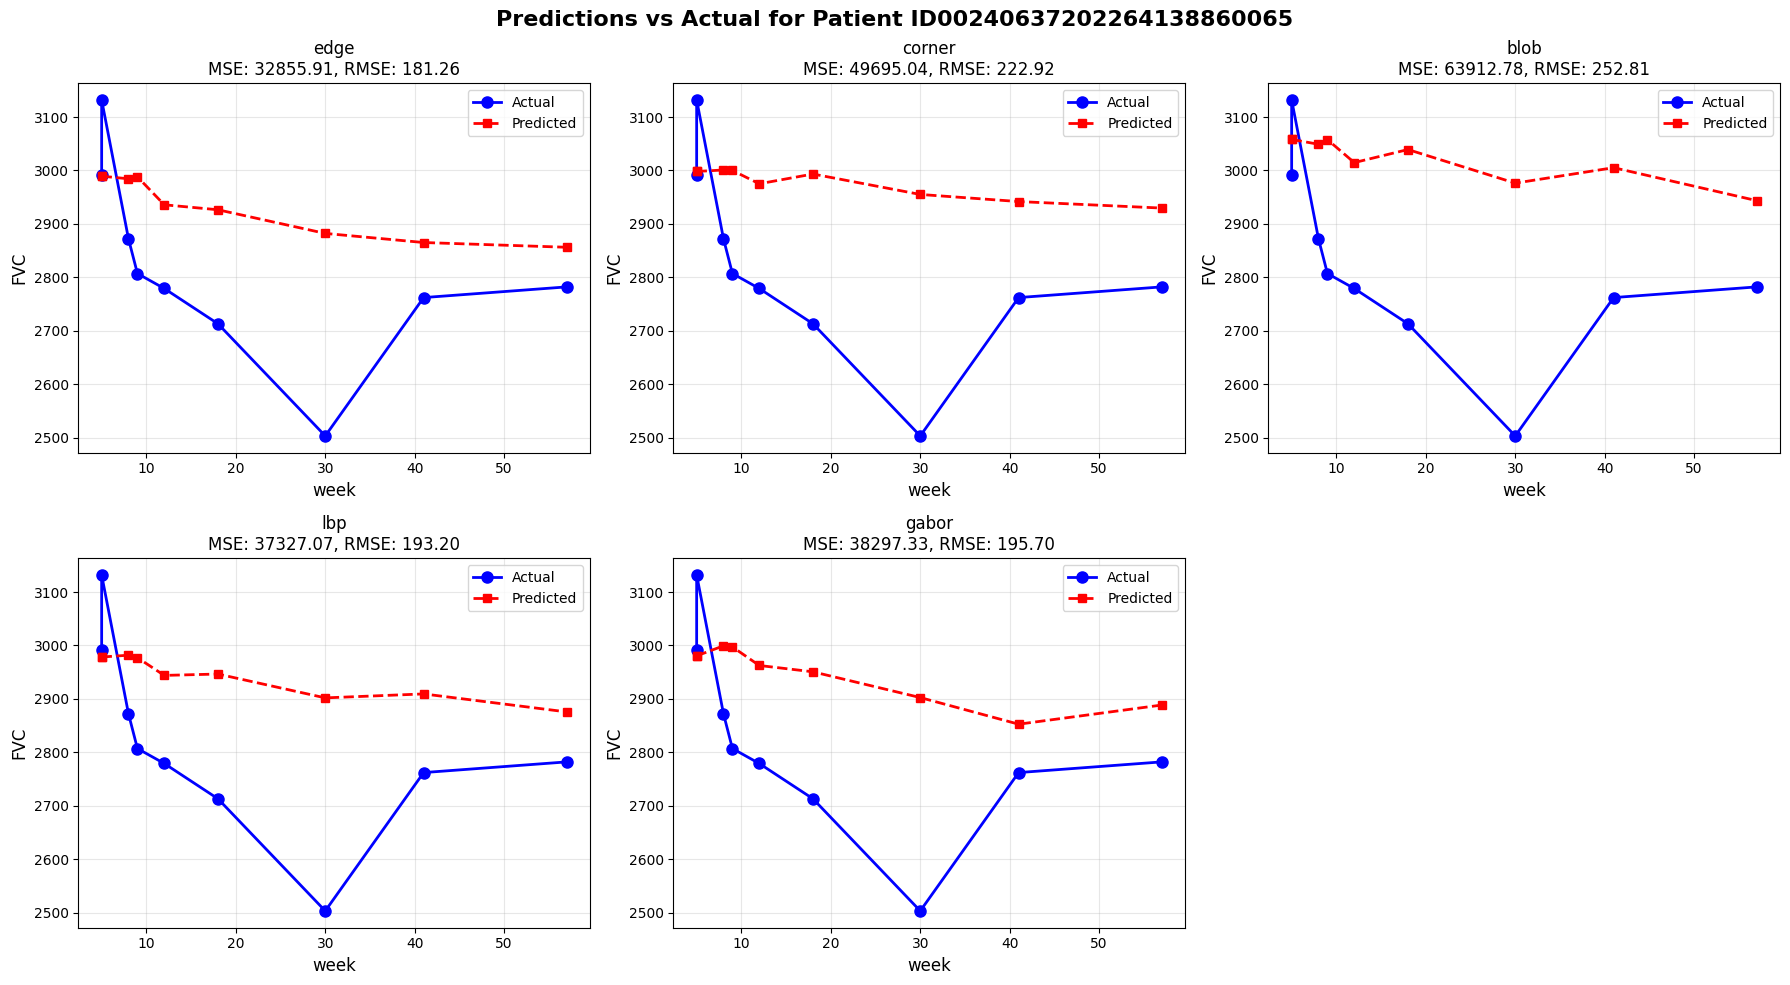


Patient ID00240637202264138860065 Summary:
Number of data points: 9
Weeks range: 5.0 to 57.0
FVC range: 2503.0 to 3132.0

Model Performance:
  edge                      MSE: 32855.91  RMSE:   181.26
  corner                    MSE: 49695.04  RMSE:   222.92
  blob                      MSE: 63912.78  RMSE:   252.81
  lbp                       MSE: 37327.07  RMSE:   193.20
  gabor                     MSE: 38297.33  RMSE:   195.70


In [81]:
patient_id = random.choice(list(x_val.keys()))
x = x_val[patient_id]
y = y_val[patient_id]

patient_predictions = {i: [] for i in range(5)}
patient_actual = []
patient_weeks = []

# Check if patient scans are available
patient_scans = load_patient_scans(patient_id, scan_batch_size=64)
if patient_scans is None:
    print(f"Could not load scans for {patient_id}")
    
# Extract features from each feature extractor
extracted_features = []
for i in range(5):
    feature = idx_to_feature_extractor[i](patient_scans, batching=True)
    feature = np.array([f.flatten() for f in feature])
    feature = np.mean(feature, axis=0).reshape(1, -1)
    feature = pcas[i].transform(feature)
    feature = feature.flatten()
    extracted_features.append(feature)

# Make predictions for each data point with all 5 models
for j in range(len(x_val[patient_id])):
    x = x_val[patient_id][j]
    y = y_val[patient_id][j]
    
    # Store actual values and weeks (only once)
    patient_actual.append(y)
    patient_weeks.append(x['week'])
    
    # Predict with each model
    for i in range(5):
        feature_vector = np.array(extracted_features[i].tolist() + list(x.values()))
        prediction = rf_regressors[i].predict(feature_vector.reshape(1, -1))[0]
        patient_predictions[i].append(prediction)

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i in range(5):
    ax = axes[i]
    
    # Sort by weeks for cleaner line plot
    sorted_indices = np.argsort(patient_weeks)
    weeks_sorted = np.array(patient_weeks)[sorted_indices]
    actual_sorted = np.array(patient_actual)[sorted_indices]
    pred_sorted = np.array(patient_predictions[i])[sorted_indices]
    
    # Plot actual vs predicted over time
    ax.plot(weeks_sorted, actual_sorted, 'o-', label='Actual', color='blue', linewidth=2, markersize=8)
    ax.plot(weeks_sorted, pred_sorted, 's--', label='Predicted', color='red', linewidth=2, markersize=6)
    
    # Calculate MSE for this patient
    mse = mean_squared_error(patient_actual, patient_predictions[i])
    rmse = np.sqrt(mse)
    
    ax.set_xlabel('week', fontsize=12)
    ax.set_ylabel('FVC', fontsize=12)
    ax.set_title(f'{idx_to_feature_name[i]}\nMSE: {mse:.2f}, RMSE: {rmse:.2f}', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

# Remove extra subplot
axes[5].remove()

plt.suptitle(f'Predictions vs Actual for Patient {patient_id}', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n{'='*60}")
print(f"Patient {patient_id} Summary:")
print(f"{'='*60}")
print(f"Number of data points: {len(patient_actual)}")
print(f"Weeks range: {min(patient_weeks):.1f} to {max(patient_weeks):.1f}")
print(f"FVC range: {min(patient_actual):.1f} to {max(patient_actual):.1f}")
print(f"\nModel Performance:")
for i in range(5):
    mse = mean_squared_error(patient_actual, patient_predictions[i])
    print(f"  {idx_to_feature_name[i]:25s} MSE: {mse:8.2f}  RMSE: {np.sqrt(mse):8.2f}")